# Banana Ripeness Classification

## Image preparation

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Removing invalid images

In [3]:
import cv2
import imghdr

/var/folders/71/z1p57v9j3xx9mtyxfmr4bw5m0000gn/T/ipykernel_11551/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'
os.listdir(data_dir)
# os.listdir(os.path.join(data_dir, 'unripe'))

['.DS_Store', 'unripe', 'ripe']

In [5]:
# Image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            if image == '.DS_Store':
                continue  # Skip .DS_Store files
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print("Image not in ext list: {}".format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print("Issue with image {}: {}".format(image_path, e))
                os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### Load data

In [10]:
from matplotlib import pyplot as plt
import numpy as np

In [12]:
# Create a dataset of those images using keras utils (building our data pipeline)
data = tf.keras.utils.image_dataset_from_directory('data')

Found 322 files belonging to 2 classes.


In [15]:
# Create a data iterator -> allow us to access the data pipeline
data_iterator = data.as_numpy_iterator()

In [17]:
# Get a batch of data from the data pipeline
batch = data_iterator.next()

2024-03-09 16:48:08.891563: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-09 16:48:08.969030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-09 16:48:09.525605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


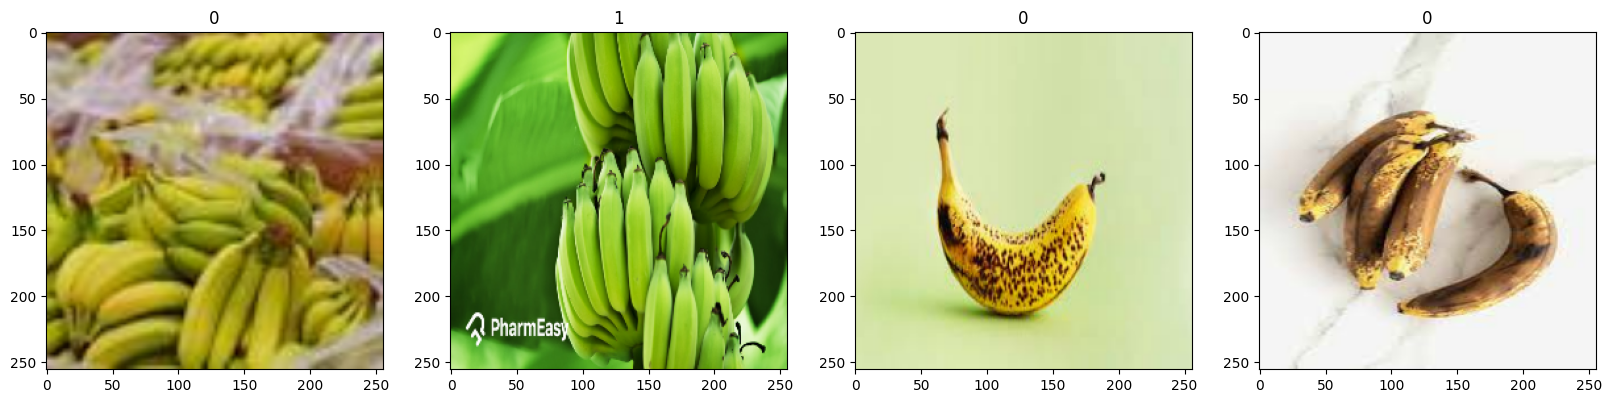

In [18]:
# Visualize a batch 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Based on this batch, 0 represents the ripe bananas and 1 represents the unripe bananas.


CLASS 1 = UNRIPE 
CLASS 0 = RIPE